# Model building - VAR

Source for how to use statsmodels VAR model for data showing seasonality: https://stats.stackexchange.com/questions/253355/time-series-data-with-seasonality-using-var#:~:text=2%20Answers&text=VAR%20models%20are%20routinely%20used,GDP%20or%20unemployment)%20are%20seasonal.
Source for code: Mahdi Shadkham-Farokhi - General Assembly - Time Series analysis lesson.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import six
import joblib
import sys
sys.modules['sklearn.externals.six'] = six
sys.modules['sklearn.externals.joblib'] = joblib

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR

from pmdarima import auto_arima

from sklearn.metrics import r2_score, mean_squared_error

In [2]:
df = pd.read_csv("./data/WQ_FINAL_with_Parameters.csv", parse_dates=['Date_Time'], index_col=['Date_Time'])

In [3]:
df.shape

(29774, 42)

In [4]:
df.head(2)

,SampleId,SampleDepth,Agency,Cruise,Database,HUC12,Latitude,Layer,Longitude,Method,...,Parameter_SALINITY,Parameter_SECCHI,Parameter_TALK,Parameter_TDS,Parameter_TKNW,Parameter_TN,Parameter_TP,Parameter_TSS,Parameter_TURB_NTU,Parameter_WTEMP
Date_Time,,,,,,,,,,,,,,,,,,,,,
2005-07-11 08:30:00,29047.0,0.5,MDDNR,BAY422,CBP,2.070011e+10,38.3626,S,-76.99063,L01,...,4.28,0.5,58.0,0.0,0.0,0.99,0.0729,7.9,8.0,27.7
2005-07-11 08:30:00,29047.0,1.0,MDDNR,BAY422,CBP,2.070011e+10,38.3626,M,-76.99063,F01,...,4.31,0.0,0.0,0.0,0.0,0.00,0.0000,0.0,0.0,27.6


**Note:** 
we can separate data
- by HUCNAME (use avarage parameter values by day)
- by SampleDepth (aggregate data for depths where not many sampling points)

**Separate Data by HUCNAME**

In [5]:
# check the amount of datapoints available for each HUC station
# df[['HUCNAME_']].value_counts(normalize=True)

In [6]:
# df.groupby(by='SampleDepth')

In [7]:
# outlet = df.loc[(df['HUCNAME_'] == 'Outlet Potomac River')][['SampleDepth', 'Parameter_CHLA', 'Parameter_DO',
#        'Parameter_NH4F', 'Parameter_NO3F', 'Parameter_PH', 'Parameter_PO4F',
#        'Parameter_SALINITY', 'Parameter_SECCHI', 'Parameter_TALK',
#        'Parameter_TDS', 'Parameter_TKNW', 'Parameter_TN', 'Parameter_TP',
#        'Parameter_TSS', 'Parameter_TURB_NTU', 'Parameter_WTEMP']]

In [8]:
# plt.figure(figsize=(20, 8))
# outlet.groupby(by='SampleDepth')['Parameter_CHLA'].count().sort_values(ascending=False).plot(kind='bar');
# plt.ylim(bottom=100);

**Select parameter columns**

In [9]:
def parameter_columns(dataframe):
    """
    function 
    selects parameter columns
    returns dataframe of parameters
    """
    param_cols = []
    for col in dataframe.columns:
        if 'Parameter' in col:
            param_cols.append(col)
#     print(param_cols)
    return dataframe[param_cols]

In [10]:
# create new dataset with only the parameter columns
params = parameter_columns(df)

In [11]:
# sort dataframe by date_time index 
params.sort_index(ascending = True, inplace=True)

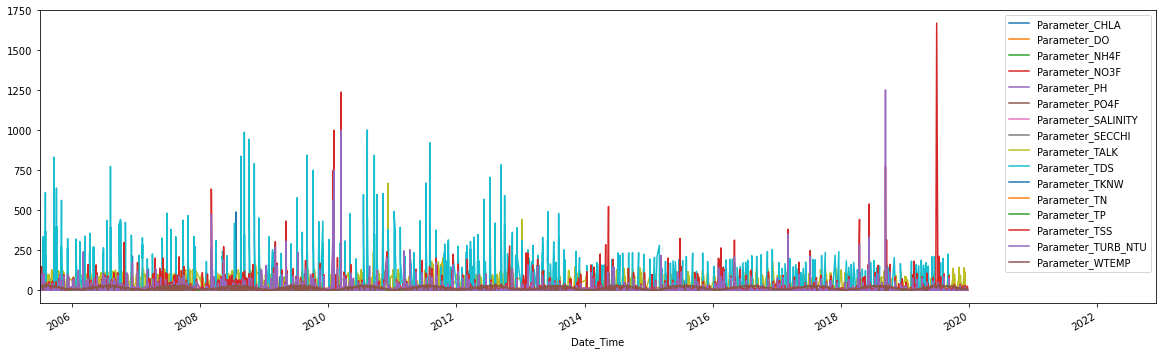

In [12]:
#visually quick_inspect data

params.plot(legend='right', xlim=('2005-07-01', '2022-12-01'), figsize=(20, 6));


**Note:** At first glance, it seems that 
- there was an uncharacteristic upsurge of TSS (Total Suspended Solids) in 2019 (or beginning of 2020) - wonder what could have happened
- level of TDS (Total Dissolved Solids flattened out after 2014)
- water tempreture seems seasonal - as expected

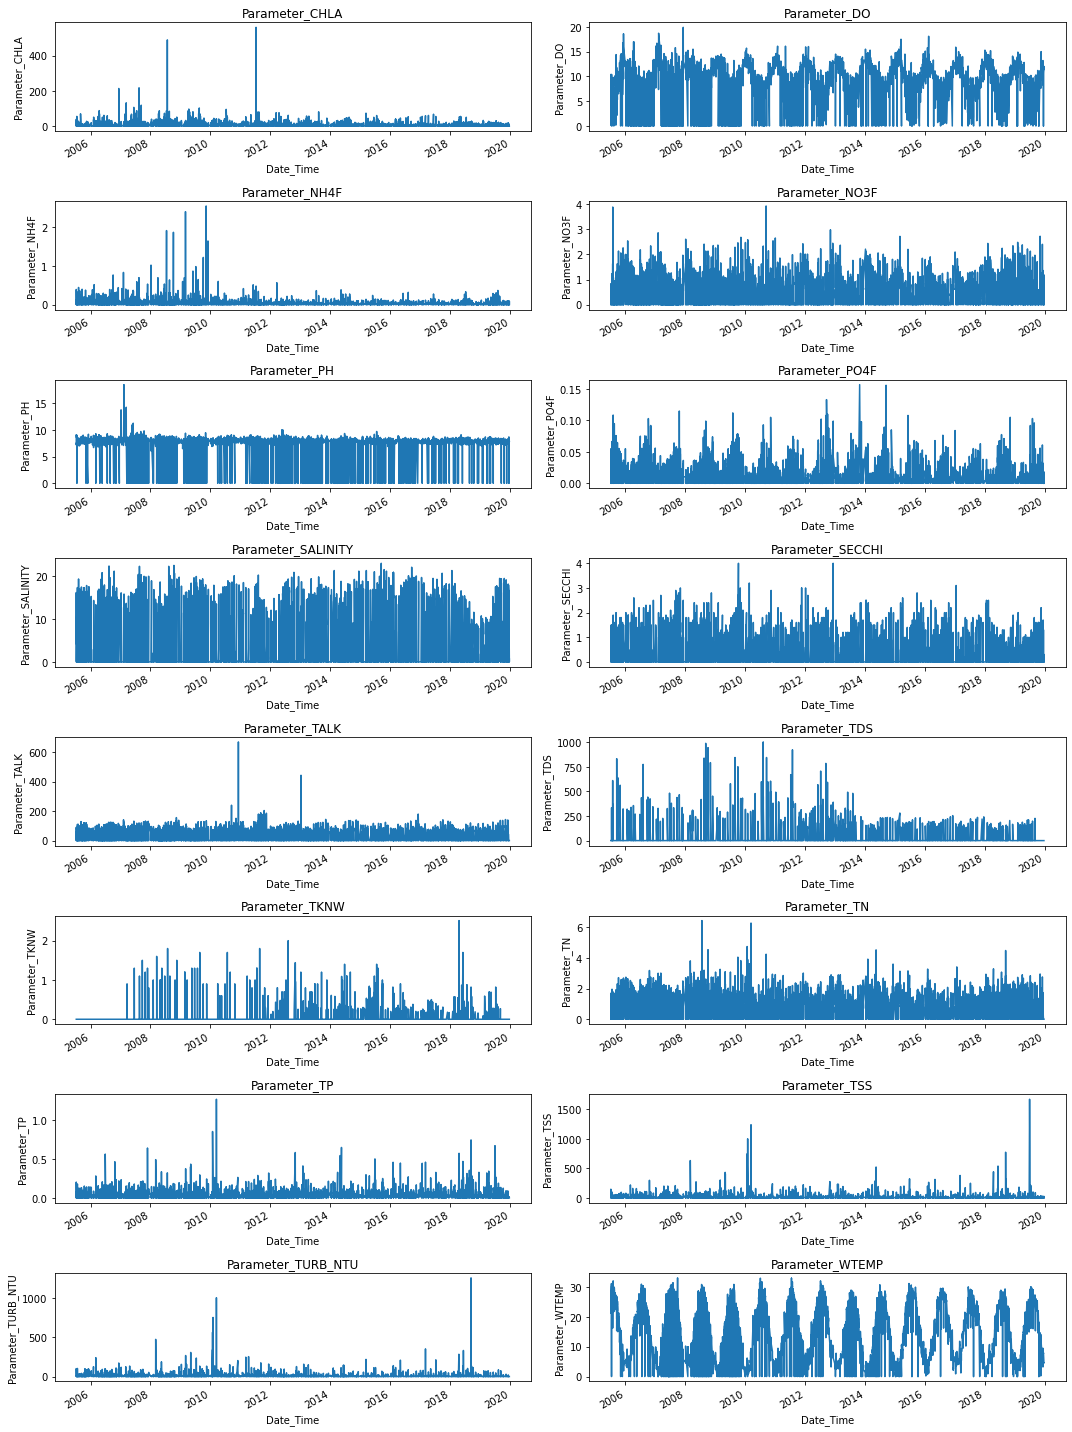

In [13]:
# Mahdi's code

fig, axes = plt.subplots(figsize = (15, 20), ncols=2, nrows=8)

# flatten axes 
axes = axes.flatten()

for i in range(16):
    ax = axes[i]
    col_name = params.columns[i]
    ax.set_title(col_name)
    ax.set_xlabel("Date_Time")
    ax.set_ylabel(col_name)
    params[col_name].plot(ax = ax)
    
plt.tight_layout()

In [14]:
# resample data to weekly periods
weekly_params = params.resample('W').mean()

In [15]:
daily_params = params.resample('D').mean()

In [16]:
params.shape

(29774, 16)

In [17]:
weekly_params.shape

(755, 16)

In [18]:
daily_params.shape

(5279, 16)

In [19]:
daily_params.dropna(inplace=True)

In [20]:
weekly_params.columns

Index(['Parameter_CHLA', 'Parameter_DO', 'Parameter_NH4F', 'Parameter_NO3F',
       'Parameter_PH', 'Parameter_PO4F', 'Parameter_SALINITY',
       'Parameter_SECCHI', 'Parameter_TALK', 'Parameter_TDS', 'Parameter_TKNW',
       'Parameter_TN', 'Parameter_TP', 'Parameter_TSS', 'Parameter_TURB_NTU',
       'Parameter_WTEMP'],
      dtype='object')

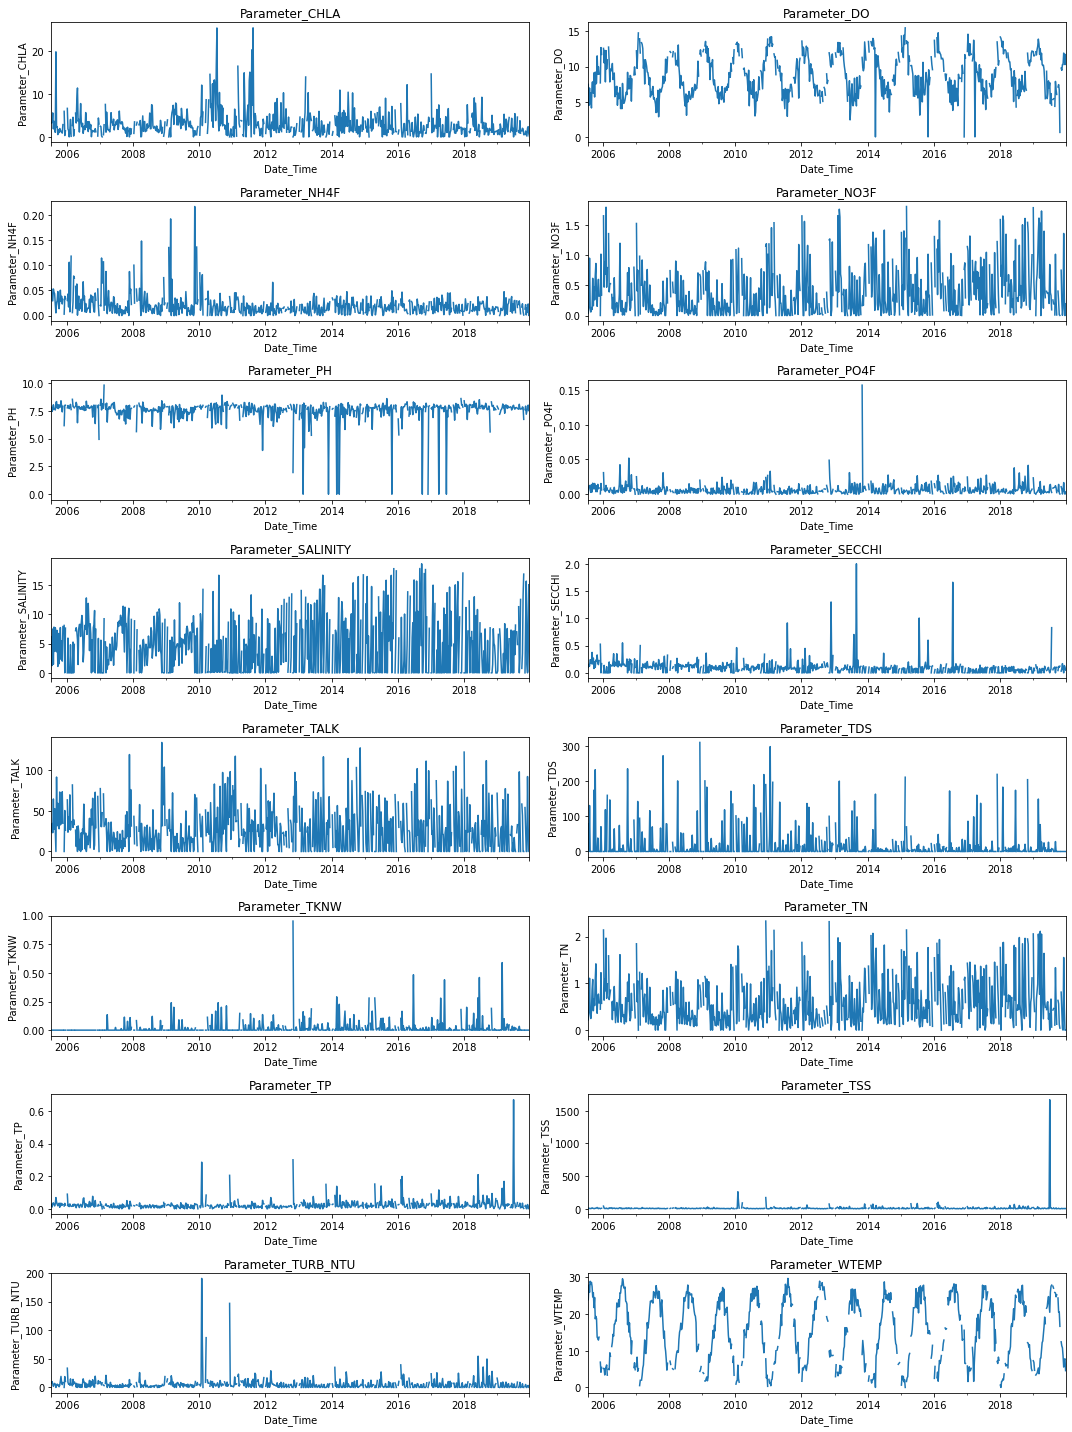

In [21]:
fig, axes = plt.subplots(figsize = (15, 20), ncols=2, nrows=8)

# flatten axes 
axes = axes.flatten()

for i in range(16):
    ax = axes[i]
    col_name = weekly_params.columns[i]
    ax.set_title(col_name)
    ax.set_xlabel("Date_Time")
    ax.set_ylabel(col_name)
    weekly_params[col_name].plot(ax = ax)
    
plt.tight_layout()

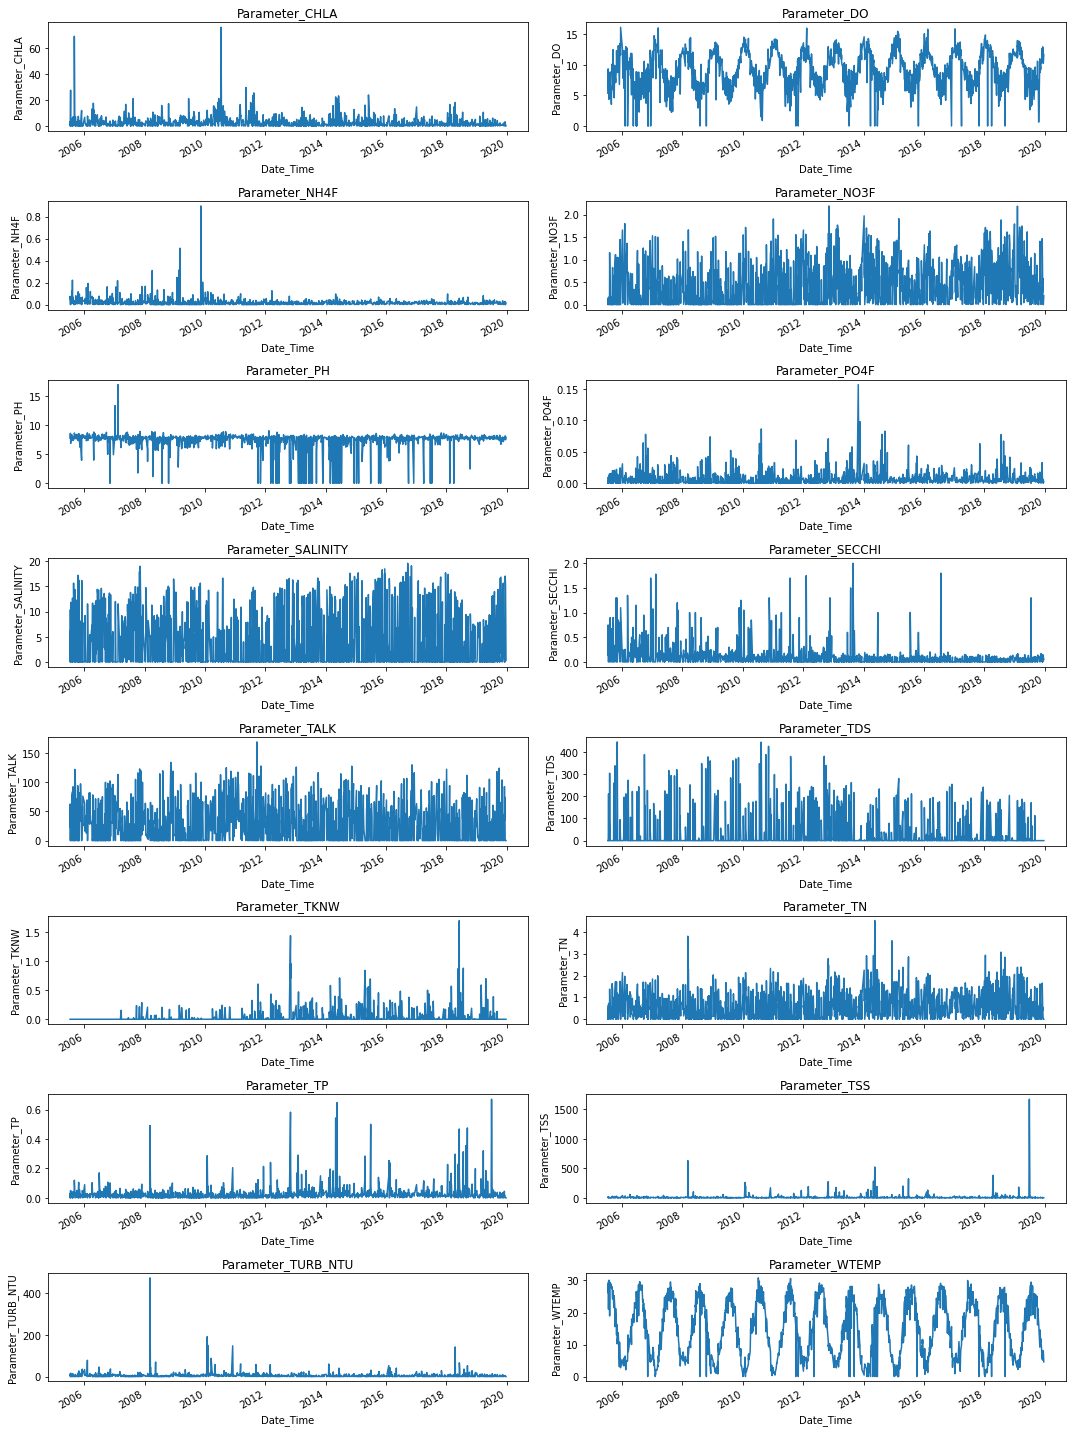

In [22]:
# plot daily data
fig, axes = plt.subplots(figsize = (15, 20), ncols=2, nrows=8)

# flatten axes 
axes = axes.flatten()

for i in range(16):
    ax = axes[i]
    col_name = daily_params.columns[i]
    ax.set_title(col_name)
    ax.set_xlabel("Date_Time")
    ax.set_ylabel(col_name)
    daily_params[col_name].plot(ax = ax)
    
plt.tight_layout()

In [23]:
# # quick line plot
# for col in weekly_params.columns:
#     plt.figure(figsize=(20, 4))
#     plt.title(col)
#     weekly_params[col].plot();

#### Seasonal Decomposition of variables that show seasonality

In [24]:
params.columns

Index(['Parameter_CHLA', 'Parameter_DO', 'Parameter_NH4F', 'Parameter_NO3F',
       'Parameter_PH', 'Parameter_PO4F', 'Parameter_SALINITY',
       'Parameter_SECCHI', 'Parameter_TALK', 'Parameter_TDS', 'Parameter_TKNW',
       'Parameter_TN', 'Parameter_TP', 'Parameter_TSS', 'Parameter_TURB_NTU',
       'Parameter_WTEMP'],
      dtype='object')

In [25]:
weekly_params = weekly_params.dropna()
weekly_params.isna().sum().sum()

0

In [26]:

# weekly_trunc = params.loc[params.index > '2017-01-01']

In [27]:
# create function to plot seasonal decomposition

def decompose(parameter, model, period):
    """
    function
    takes parameter as dataframe, model, period
    plot seasonal decomposition
    """
    decomp = seasonal_decompose(parameter, model=model, period=period)
    decomp.plot();

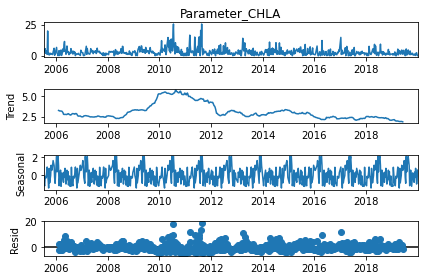

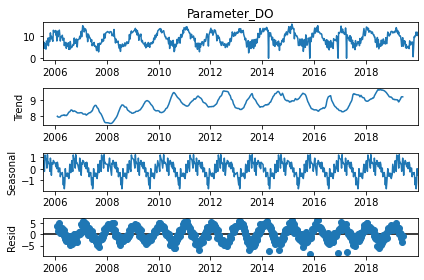

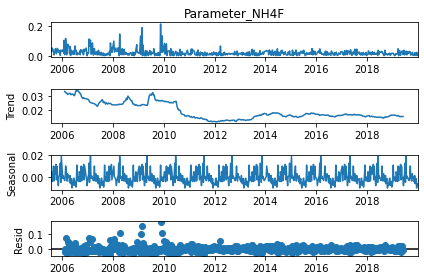

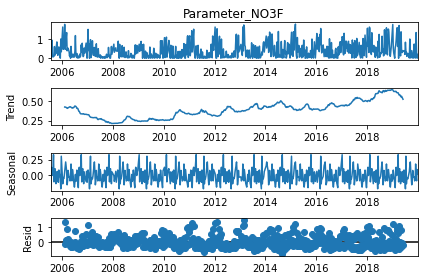

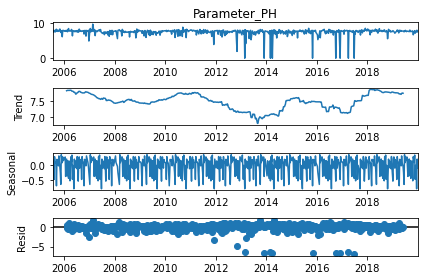

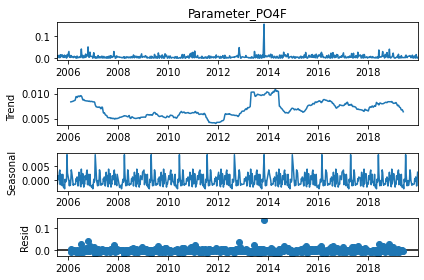

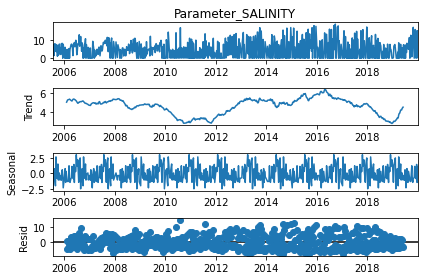

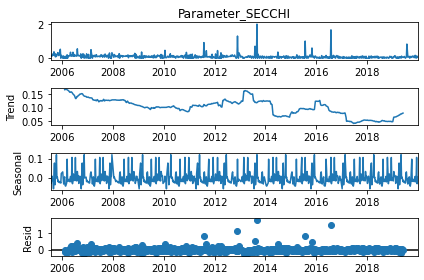

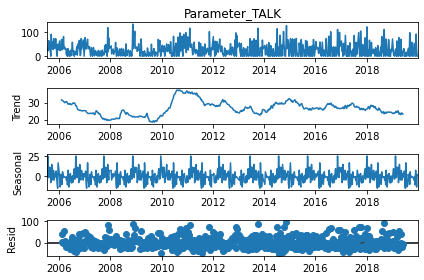

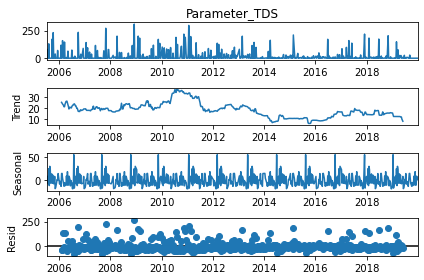

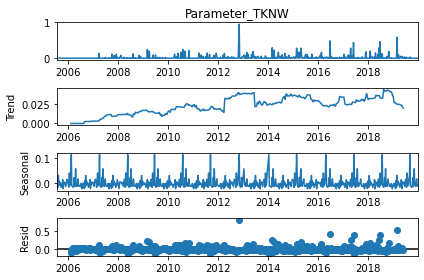

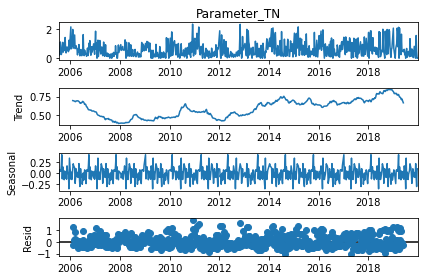

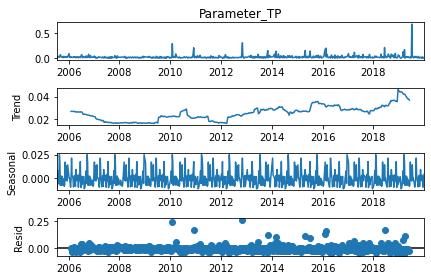

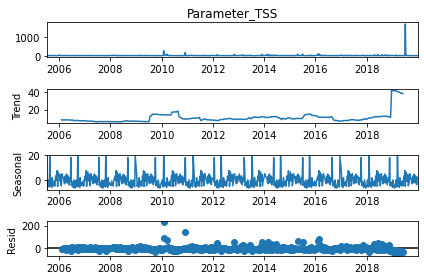

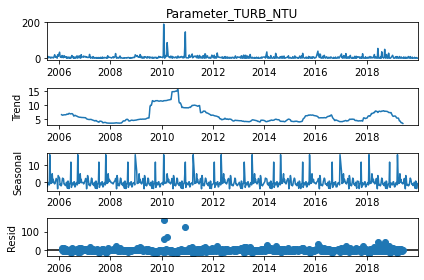

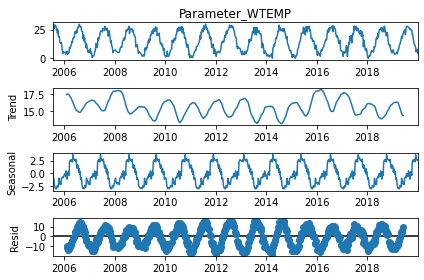

In [28]:
# plot seasonal decomposition for each parameter in truncated dataframe (df) - weekly aggregate
# model = additive
# period = 52 (weekly seasonality) 

cols = weekly_params.columns
for col in cols:
    decompose(parameter=weekly_params[col],
              model='additive',
              period=52)
    
    # seasonality looks yearly

In [29]:
# look at the standard deviation to eyeball whether seasonality is significant in any of the variables

weekly_params.describe()

,Parameter_CHLA,Parameter_DO,Parameter_NH4F,Parameter_NO3F,Parameter_PH,Parameter_PO4F,Parameter_SALINITY,Parameter_SECCHI,Parameter_TALK,Parameter_TDS,Parameter_TKNW,Parameter_TN,Parameter_TP,Parameter_TSS,Parameter_TURB_NTU,Parameter_WTEMP
count,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000
mean,3.035490,8.726213,0.019829,0.393478,7.502837,0.006975,4.609904,0.102684,26.972654,18.296739,0.021612,0.590621,0.025499,11.679982,5.962018,15.578044
std,3.102052,2.824572,0.020977,0.412207,1.059492,0.008915,4.635298,0.147697,26.669192,45.623474,0.068572,0.500616,0.037798,66.524687,11.888008,8.534343
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.191238,6.600224,0.007600,0.073405,7.451800,0.002273,0.000000,0.029412,2.206082,0.000000,0.000000,0.223567,0.010932,2.581527,0.527076,7.539526
50%,2.212630,8.499351,0.015734,0.257841,7.738856,0.004952,3.916591,0.087500,22.950591,0.000000,0.000000,0.461245,0.018720,5.057009,3.744525,16.427515
75%,3.809883,11.050000,0.024906,0.598953,7.918293,0.008882,7.717019,0.127972,38.453750,9.810702,0.008123,0.819379,0.029467,9.989750,7.321635,23.512727
max,25.491538,15.500000,0.216308,1.810200,9.806800,0.157000,18.588333,2.000000,133.833333,309.750000,0.952500,2.331500,0.670000,1670.000000,190.642857,29.745472


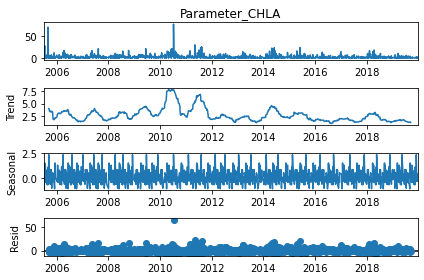

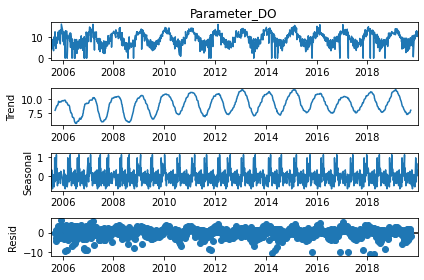

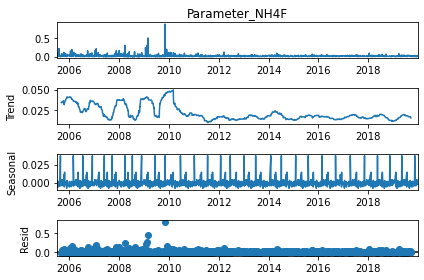

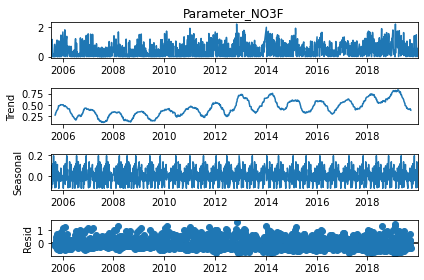

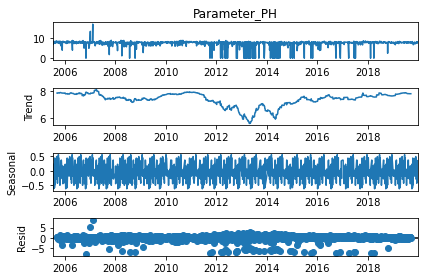

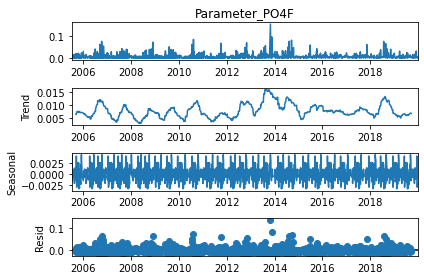

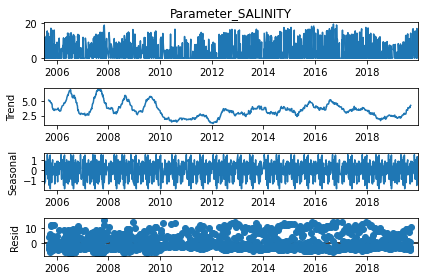

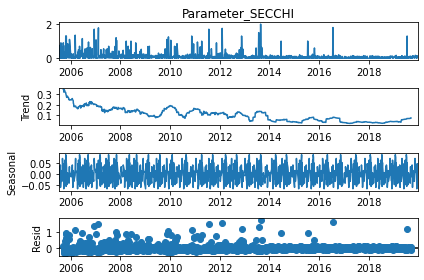

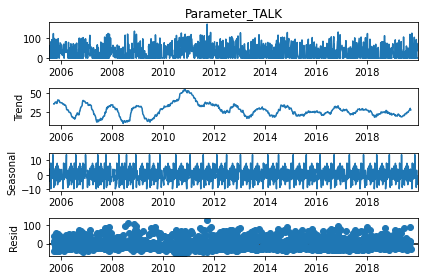

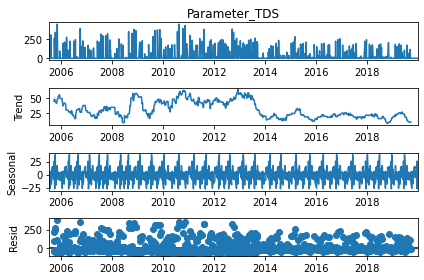

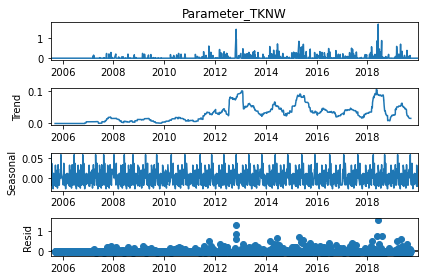

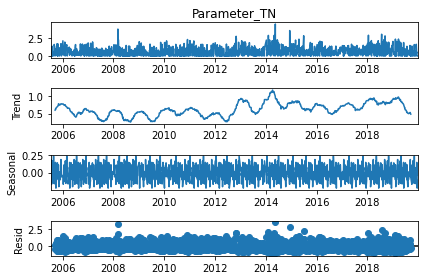

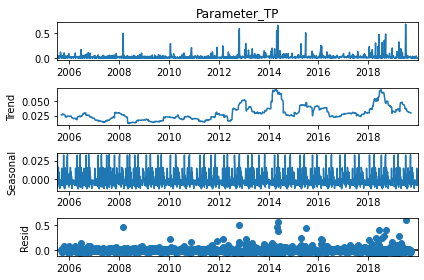

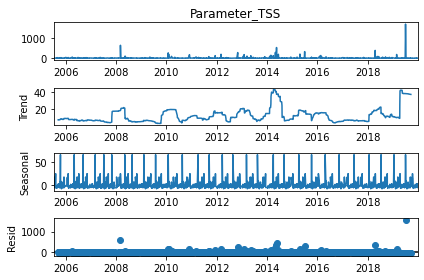

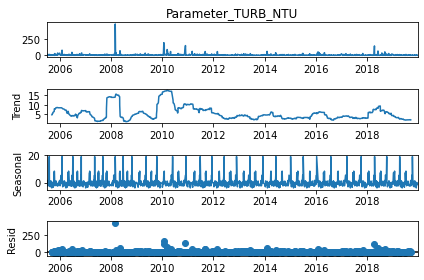

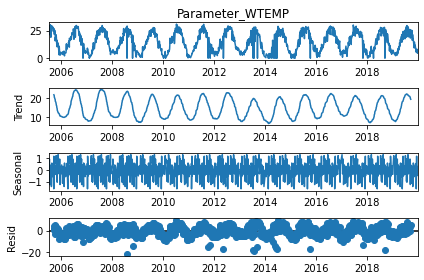

In [30]:
# plot seasonal decomposition for each parameter in truncated dataframe (df) - daily aggregate
# model = additive
# period = 7 (daily periods) 

cols = daily_params.columns
for col in cols:
    decompose(parameter=daily_params[col],
              model='additive',
              period=52)
    
    # seasonality looks yearly daily_params

**Autocorrelation Plots**

In [31]:
# function to plot autocorrelation and partial autocorrelation

def autocorrelation(df, lags):
    plot_acf(df, lags=lags);
    plot_pacf(df, lags=lags);

Parameter_CHLA


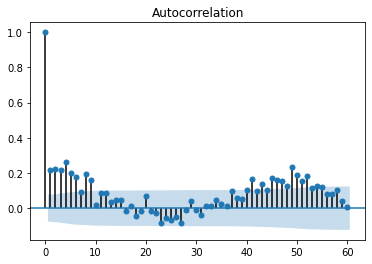

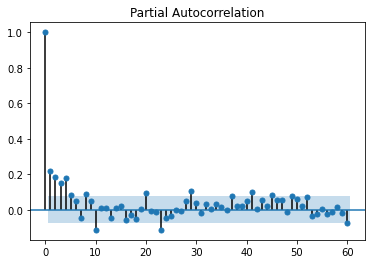

In [32]:
# plot autocorrelation for Clorophyll - weekly aggregates
print(cols[0])
autocorrelation(weekly_params[cols[0]], lags=60);

Clorophyll seems to have seasonality - roughly 1 year periods, no trend (the small lag values have relatively small, albiet positive, autocorrelation values).

Parameter_DO


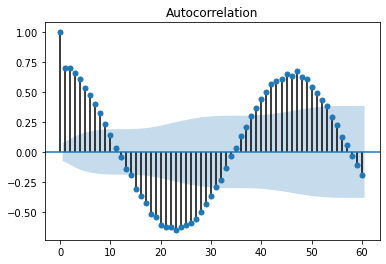

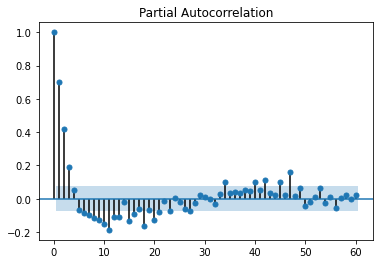

In [33]:
# plot autocorrelation for Dissolved Oxygen - weekly aggregates
print(cols[1])
autocorrelation(weekly_params[cols[1]], lags=60);

Dissolved oxygen - shows seasonality - roughly 1 year periods.
Trend: follows changes of physical seasons.

Parameter_NH4F


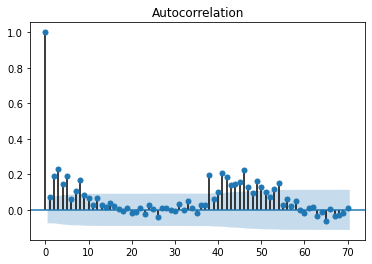

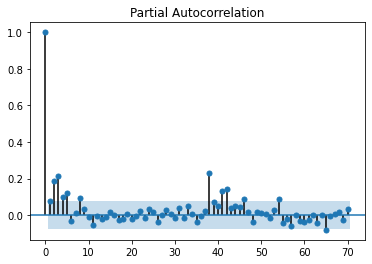

In [34]:
# plot autocorrelation for Ammonia nitrogen - weekly aggregates
print(cols[2])
autocorrelation(weekly_params[cols[2]], lags=70);

Ammonia nitrogen - shows seasonal tendency - around 40 weeks, no trend(?).

Parameter_NO3F


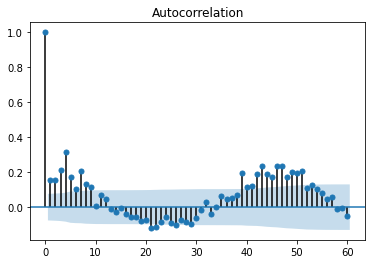

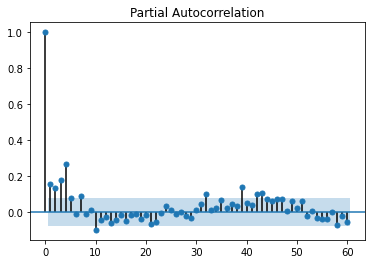

In [35]:
# plot autocorrelation for Nitrate Nitrogen - weekly aggregates
print(cols[3])
autocorrelation(weekly_params[cols[3]], lags=60);

Nitrate Nitrogen - shows seasonal changes (less than 1 year). No trend(?).

Parameter_PH


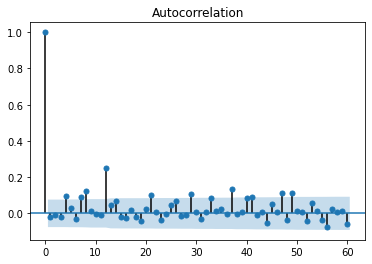

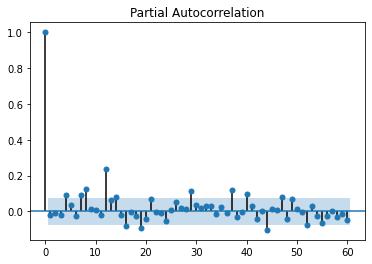

In [36]:
# plot autocorrelation for PH level (corrected for temperature) - weekly aggregates
print(cols[4])
autocorrelation(weekly_params[cols[4]], lags=60);

PH level (corrected for temperature) - no seasonality, no trend. Lag 12 and 38 are the most important predictors.

Parameter_PO4F


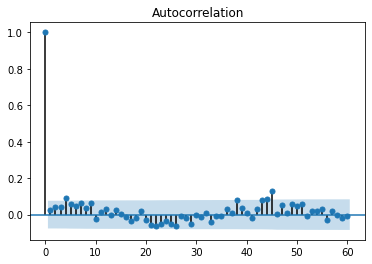

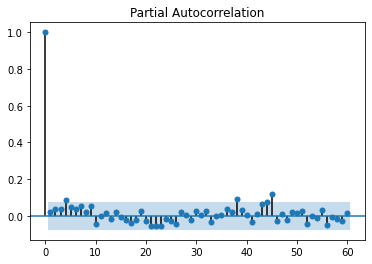

In [37]:
# plot autocorrelation for Orthophosphate Phosphorus - weekly aggregates
print(cols[5])
autocorrelation(weekly_params[cols[5]], lags=60);

Orthophosphate Phosphorus - no seasonality, no trend. Lag 45 is important.

Parameter_SALINITY


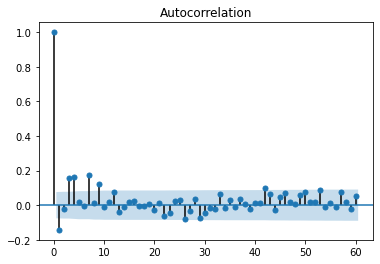

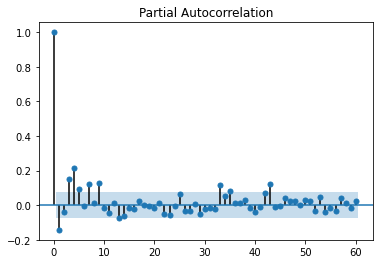

In [38]:
# plot autocorrelation for Salinity - weekly aggregates
print(cols[6])
autocorrelation(weekly_params[cols[6]], lags=60);

Salinity - not seasonal, no trend, lags 1, 3, and 4 seem important. 

Parameter_SECCHI


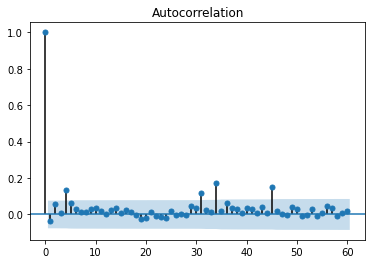

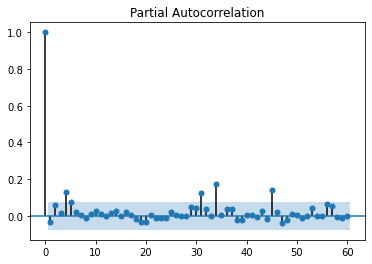

In [39]:
# plot autocorrelation for SECCHI DEPTH - weekly aggregates
print(cols[7])
autocorrelation(weekly_params[cols[7]], lags=60);

Secchi depth - no seasonality, no trend, lags 4, 32, 36 and 45 seem important. 

Parameter_TALK


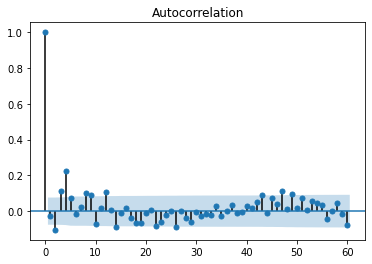

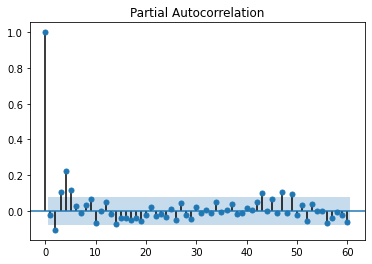

In [40]:
# plot autocorrelation for Total Alkalinity - weekly aggregates
print(cols[8])
autocorrelation(weekly_params[cols[8]], lags=60);

Total Alkalinity - no seasonality (?), no trend, lag 2, 3, 4 and 47 seem important.

Parameter_TDS


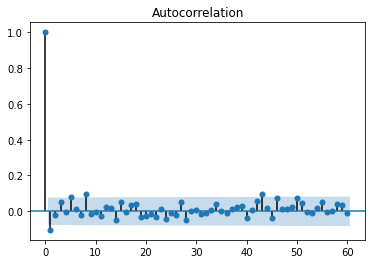

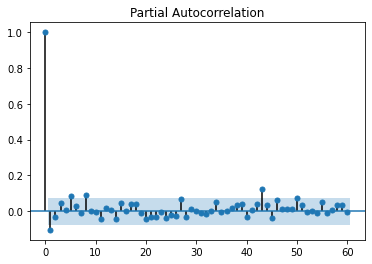

In [41]:
# plot autocorrelation for Total Dissolved Solids - weekly aggregates
print(cols[9])
autocorrelation(weekly_params[cols[9]], lags=60);

Total Dissolved Solids - no seasonality, no trend, lag 1 and 43 seems important.

Parameter_TKNW


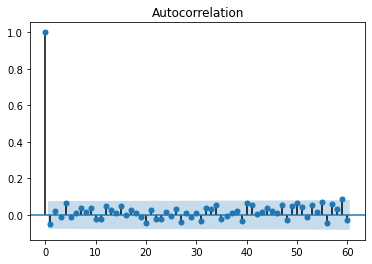

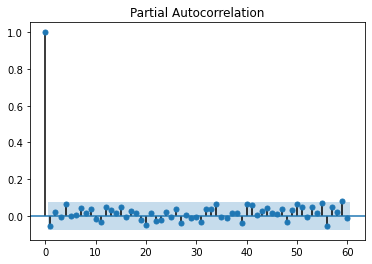

In [42]:
# plot autocorrelation for Total Kjedahl Nitrogen - weekly aggregates
print(cols[10])
autocorrelation(weekly_params[cols[10]], lags=60);

Total Kjedahl Nitrogen - no seasonality, no trend.

Parameter_TN


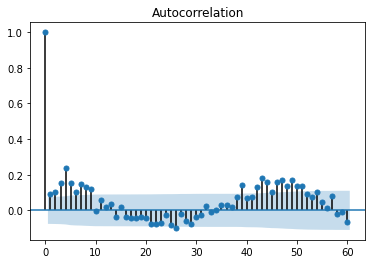

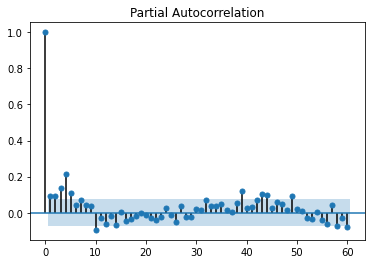

In [43]:
# plot autocorrelation for Total Nitrogen - weekly aggregates
print(cols[11])
autocorrelation(weekly_params[cols[11]], lags=60);

Total Nitrogen - shows seasonality (?), no trend, roughly yearly.

Parameter_TP


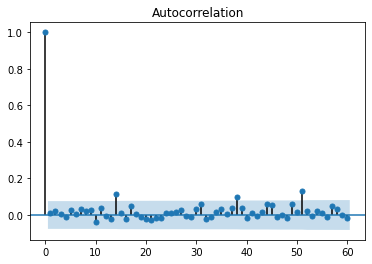

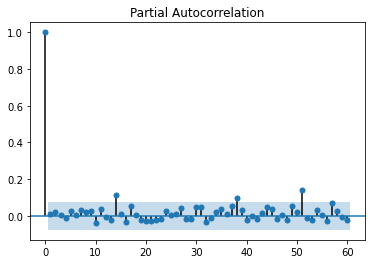

In [44]:
# plot autocorrelation for Total Phosphorus - weekly aggregates
print(cols[12])
autocorrelation(weekly_params[cols[12]], lags=60);

Total Phosphorus - no seasonality, not trend, important lags: 14, 51.

Parameter_TSS


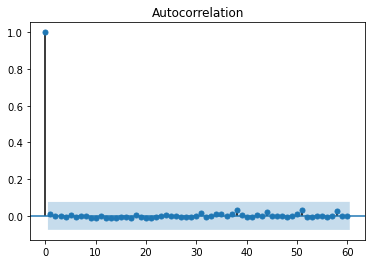

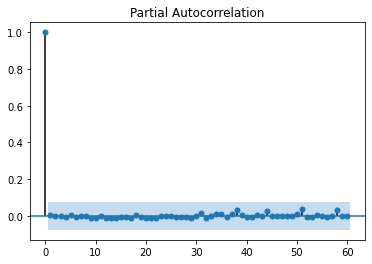

In [45]:
# plot autocorrelation for Total Suspended Solids - weekly aggregates
print(cols[13])
autocorrelation(weekly_params[cols[13]], lags=60);

Total suspended solids - no trend, no seasonality. 

Parameter_TURB_NTU


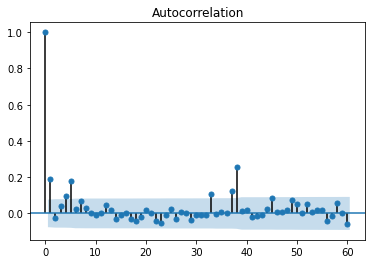

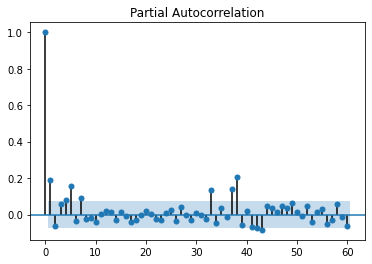

In [46]:
# plot autocorrelation for Turbidity - Nephelometric Method - weekly aggregates
print(cols[14])
autocorrelation(weekly_params[cols[14]], lags=60);

Water Clarity (turbidity, nephelometric method - used to test post filtration water clarity) - no seasonality, no trend. Important lags: 1, 5, 32, 38. <br>
source: https://www.hach.com/turbidity-article-turbidity101

Parameter_WTEMP


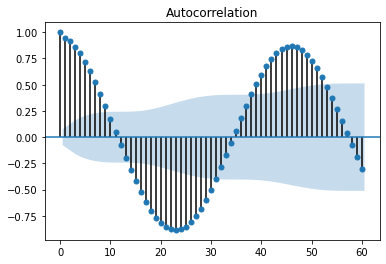

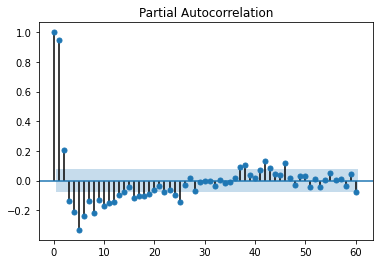

In [47]:
# plot autocorrelation for Water Temperature - weekly aggregates
print(cols[15])
autocorrelation(weekly_params[cols[15]], lags=60);

Water Temperature - shows seasonality (yearly), trend follows sine wave. Important lags: 1, 2, 5.

**Drop Parameter_TURB_NTU - and used only SECCHI as a metric for turbidity**

In [48]:
weekly_df = weekly_params.drop(columns=['Parameter_TURB_NTU'])

In [49]:
daily_df = daily_params.drop(columns=['Parameter_TURB_NTU'])

In [50]:
daily_params.shape

(1540, 16)

In [51]:
# make sure the data is in daily increments

daily_df.resample('D').mean().shape

(5279, 15)

In [52]:
cols_df = weekly_df.columns

**Establish stationarity**<br>
Daily Aggregates

In [53]:
# conduct Augmented Dicky-Fuller test - print test statistic and p-value

def interpret_adftest(target_column):
    '''Returns the Test Statistic and p-value for Augmented Dickey-Fuller test on given target column'''
    test = adfuller(target_column)
    output = pd.Series(test[0:2], index=['Test Statistic','p-value'])
    return output

# source: Mahdi

In [54]:
# print out Dicky_Fuller test interpretations for each variable

for col in cols_df:
    test_stats = interpret_adftest(daily_df[col])
    print(test_stats)
    if test_stats[1] > 0.05:
        print(f'{col} not stationary')
    else:
        print(f'{col} stationary')
    print('')

Test Statistic   -5.356626
p-value           0.000004
dtype: float64
Parameter_CHLA stationary

Test Statistic   -8.250394e+00
p-value           5.410669e-13
dtype: float64
Parameter_DO stationary

Test Statistic   -8.818157e+00
p-value           1.909205e-14
dtype: float64
Parameter_NH4F stationary

Test Statistic   -5.336522
p-value           0.000005
dtype: float64
Parameter_NO3F stationary

Test Statistic   -5.326006
p-value           0.000005
dtype: float64
Parameter_PH stationary

Test Statistic   -8.061974e+00
p-value           1.633792e-12
dtype: float64
Parameter_PO4F stationary

Test Statistic   -6.667893e+00
p-value           4.667269e-09
dtype: float64
Parameter_SALINITY stationary

Test Statistic   -5.241697
p-value           0.000007
dtype: float64
Parameter_SECCHI stationary

Test Statistic   -6.238767e+00
p-value           4.753682e-08
dtype: float64
Parameter_TALK stationary

Test Statistic   -21.717572
p-value            0.000000
dtype: float64
Parameter_TDS stationar

All parameters are stationary.

**VAR Model**<br>
Small dataset ==> no train-test split for trainig the model. 

In [55]:
params15 = params.drop(columns=['Parameter_TURB_NTU'])

In [56]:
params15_monthly = params15.resample('M', closed='right', convention='end').mean()

In [57]:
params15_monthly.isna().sum()

Parameter_CHLA        0
Parameter_DO          0
Parameter_NH4F        0
Parameter_NO3F        0
Parameter_PH          0
Parameter_PO4F        0
Parameter_SALINITY    0
Parameter_SECCHI      0
Parameter_TALK        0
Parameter_TDS         0
Parameter_TKNW        0
Parameter_TN          0
Parameter_TP          0
Parameter_TSS         0
Parameter_WTEMP       0
dtype: int64

In [58]:
params15_monthly.describe()

,Parameter_CHLA,Parameter_DO,Parameter_NH4F,Parameter_NO3F,Parameter_PH,Parameter_PO4F,Parameter_SALINITY,Parameter_SECCHI,Parameter_TALK,Parameter_TDS,Parameter_TKNW,Parameter_TN,Parameter_TP,Parameter_TSS,Parameter_WTEMP
count,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000
mean,3.500434,8.724226,0.020278,0.289014,7.695662,0.005858,6.045821,0.119878,23.538509,7.734264,0.007184,0.488298,0.021985,9.016082,15.212296
std,2.455028,2.549995,0.008620,0.160290,0.281659,0.002639,1.877588,0.053493,8.509686,6.836129,0.007329,0.185716,0.008492,7.309507,8.513962
min,1.045143,4.523852,0.005862,0.041610,5.500000,0.001630,2.072766,0.041667,3.665529,0.000000,0.000000,0.171307,0.009227,2.579358,1.081944
25%,2.196319,6.303140,0.014020,0.154867,7.600540,0.003458,4.790053,0.082768,19.113366,2.652930,0.000000,0.327876,0.016608,5.210272,6.862118
50%,2.932703,8.346877,0.018556,0.276456,7.715380,0.005478,6.001309,0.105603,23.702737,4.304645,0.005279,0.477001,0.020835,7.832836,15.556978
75%,4.045458,11.055121,0.023942,0.419542,7.815897,0.007692,7.376511,0.141714,28.191230,12.908868,0.011090,0.630234,0.026177,9.861040,23.224381
max,21.288172,13.307246,0.049129,0.668472,8.469794,0.012660,10.391923,0.328099,47.138462,32.694444,0.028073,0.960136,0.068319,71.851000,28.503352


In [59]:
# instantiate VAR model
var = VAR(params15_monthly)

In [60]:
# store fitted model in variable fitted_var
# use Akaike information Criterion (aic)
# trend = 'c' ==> add constant


fitted_var = var.fit(maxlags=5, ic='aic', trend='c', verbose=True);

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 4, BIC -> 1, FPE -> 1, HQIC -> 1>
Using 4 based on aic criterion


In [61]:
fitted_var.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 13, Sep, 2020
Time:                     08:35:38
--------------------------------------------------------------------
No. of Equations:         15.0000    BIC:                   -38.3586
Nobs:                     170.000    HQIC:                  -48.3877
Log likelihood:           1991.82    FPE:                1.69349e-24
AIC:                     -55.2366    Det(Omega_mle):     1.70348e-26
--------------------------------------------------------------------
Results for equation Parameter_CHLA
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                        -4.331375        11.384548           -0.380           0.704
L1.Parameter_CHLA             0.244923         0.094207            2.600           0.009
L1.Parameter_DO    

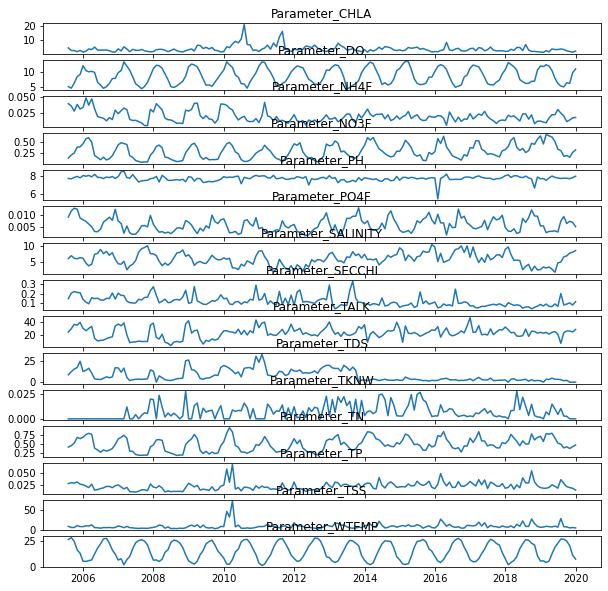

In [62]:
fitted_var.plot();


In [63]:
# to evaluate the model = split the dataset into a 'training' and a 'testing' set (0.8 - 0.2 split)
split_point = int(params15_monthly.shape[0] * 0.8)
train = params15_monthly[:split_point]
test = params15_monthly[split_point:]

In [64]:
train.head(2)

,Parameter_CHLA,Parameter_DO,Parameter_NH4F,Parameter_NO3F,Parameter_PH,Parameter_PO4F,Parameter_SALINITY,Parameter_SECCHI,Parameter_TALK,Parameter_TDS,Parameter_TKNW,Parameter_TN,Parameter_TP,Parameter_TSS,Parameter_WTEMP
Date_Time,,,,,,,,,,,,,,,
2005-07-31,4.286649,5.295977,0.040029,0.136188,7.689655,0.009002,6.177701,0.147701,24.816092,8.655172,0.0,0.409412,0.027286,8.689080,26.739655
2005-08-31,2.422721,4.783799,0.036570,0.207145,7.651955,0.011425,7.024302,0.204190,30.011173,12.402235,0.0,0.452563,0.029470,5.794413,28.503352


In [65]:
train.tail(2)

,Parameter_CHLA,Parameter_DO,Parameter_NH4F,Parameter_NO3F,Parameter_PH,Parameter_PO4F,Parameter_SALINITY,Parameter_SECCHI,Parameter_TALK,Parameter_TDS,Parameter_TKNW,Parameter_TN,Parameter_TP,Parameter_TSS,Parameter_WTEMP
Date_Time,,,,,,,,,,,,,,,
2016-12-31,3.777662,11.116923,0.024646,0.372112,7.813846,0.005778,6.538154,0.072308,47.138462,3.907692,0.002923,0.664958,0.031909,10.570769,6.675385
2017-01-31,4.040616,12.102020,0.016319,0.362217,7.702424,0.004616,9.640404,0.072727,24.262626,1.737374,0.002222,0.540159,0.026620,9.518182,4.675758


In [66]:
test.head(2)

,Parameter_CHLA,Parameter_DO,Parameter_NH4F,Parameter_NO3F,Parameter_PH,Parameter_PO4F,Parameter_SALINITY,Parameter_SECCHI,Parameter_TALK,Parameter_TDS,Parameter_TKNW,Parameter_TN,Parameter_TP,Parameter_TSS,Parameter_WTEMP
Date_Time,,,,,,,,,,,,,,,
2017-02-28,2.198704,11.837037,0.020143,0.526680,7.882716,0.004311,7.021852,0.053086,24.691358,3.740741,0.005926,0.659642,0.022278,10.981481,4.893827
2017-03-31,4.527164,11.534328,0.024025,0.526185,7.967164,0.004760,4.977463,0.053731,34.895522,5.656716,0.005224,0.846000,0.035718,19.050746,7.673134


In [67]:
test.tail(2)

,Parameter_CHLA,Parameter_DO,Parameter_NH4F,Parameter_NO3F,Parameter_PH,Parameter_PO4F,Parameter_SALINITY,Parameter_SECCHI,Parameter_TALK,Parameter_TDS,Parameter_TKNW,Parameter_TN,Parameter_TP,Parameter_TSS,Parameter_WTEMP
Date_Time,,,,,,,,,,,,,,,
2019-11-30,1.136607,9.636607,0.017916,0.264654,7.776607,0.00688,8.075893,0.08125,24.892857,0.0,0.0,0.420883,0.017500,5.651786,11.25625
2019-12-31,2.035920,10.881000,0.018616,0.320272,7.925900,0.00518,8.559800,0.11600,28.840000,0.0,0.0,0.468015,0.013551,4.644000,7.25700


In [68]:
# Mahdi's code
# get predictions and confidence intervals for "test" set
test_preds, lower_conf_ints, upper_conf_ints = fitted_var.forecast_interval(train.values, len(test))

In [69]:
lower_conf_ints[:, 1]

array([10.52677034,  9.73939139,  7.88054352,  6.16660248,  4.33009982,
        3.83634847,  3.89050378,  4.52990858,  5.66008256,  6.90765321,
        8.19260053,  8.98300922,  8.94373377,  8.0948241 ,  6.51482993,
        4.81195593,  3.49181239,  2.80471021,  2.88088127,  3.60072323,
        4.7700699 ,  6.12928477,  7.32189568,  8.0063339 ,  7.91666236,
        7.05406691,  5.6766509 ,  4.18157333,  2.97235213,  2.3294498 ,
        2.37628856,  3.06769757,  4.21858584,  5.53687228,  6.66190912])

KeyError: 'Parameter_TURB_NTU'

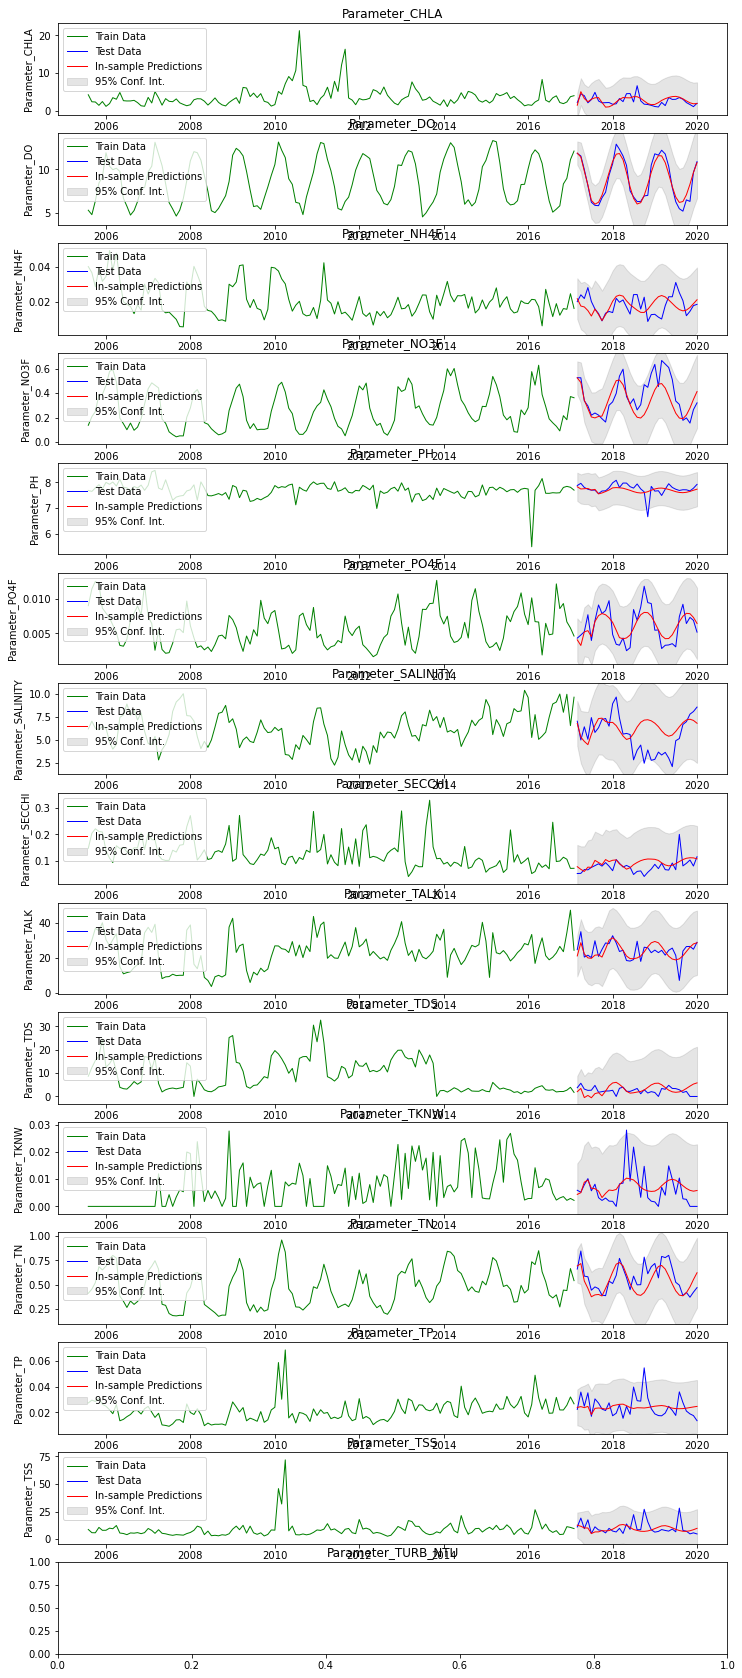

In [70]:
# Mahdi's code
# plot forecast
fig, axes = plt.subplots(figsize=(12,30), nrows = 15)

for i in range(15):
    col_name = cols[i]
    ax = axes[i]
    
    ax.set_title(col_name)
    
    train_col      = train[col_name] # pulling from pandas dataframe
    test_col       = test[col_name]  # pulling from pandas dataframe
    test_preds_col = test_preds[:,i] # pulling from numpy aray
    lower_conf_int = lower_conf_ints[:,i] # pulling from numpy aray
    upper_conf_int = upper_conf_ints[:,i] # pulling from numpy aray
    
    # Setting min and max (cuts off extreme conf. ints.)
    max_val = max([max(train_col), max(test_col)])
    min_val = min([min(train_col), min(test_col)])
    diff = max_val - min_val
    max_y = max_val + diff * 0.1
    min_y = min_val - diff * 0.1
    
    # setting min and max y limits (due to extreme conf. ints.)
    ax.set_ylim(ymin = min_y, ymax = max_y)
    
    # train data
    ax.plot(train.index, train_col, lw=1, color='green', ls='solid',label='Train Data')

    # test data
    ax.plot(test.index, test_col, lw=1, color='blue', ls='solid',label='Test Data')

    # forecast data
    ax.plot(test.index, test_preds_col, lw=1, color='red', ls="solid",  label='In-sample Predictions')
    ax.set_xlabel("Date")
    ax.set_ylabel(col_name)

    # conf ints
    ax.fill_between(test.index, lower_conf_int, upper_conf_int, color='k', alpha=0.1, label = "95% Conf. Int.");
    ax.legend(loc = "upper left")
    
plt.tight_layout();

**Note:** At this point the model does not predict well TP (total phosphorus). The in-data forecast approximates the test data well. However, I do not know how to interpret that both the forecast and the actual data points are outside the confidence interval. ==> __check what is going on__

In [ ]:
# Mahdi's code

# getting first column of predictions (Chlorophyll)
CHLA_preds = test_preds[:,0]
CHLA_true = test.iloc[:,0]
print('Clorophyll')
print('R2 score:', round(r2_score(CHLA_preds, CHLA_true), 2))




In [ ]:
# getting 13th column of predictions (Total Phosphorus)
TP_preds = test_preds[:,12]
TP_true = test.iloc[:,12]
print('Total Phosphorus')
print('R2 score:', round(r2_score(TP_preds, TP_true), 2))


**Note:** Since the majority of the parameters co-affect each other, theoretically, it makes sense to regress them on one another and predict all of them in a single time series model. The R2 scores of the two variables that we looked at (chlorophyll and total phosphorus) suggest that this approach may not work best for all parameters (a negative r2 score means that the model's predictions are worse than the mean).